In [1]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM
from keras.layers import  Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import cv2
import numpy as np
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

tf.get_logger().setLevel('ERROR')
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7615537277980678665
xla_global_id: -1
]
Device mapping: no known devices.


In [3]:
char_list = string.ascii_letters+string.digits 
def encode_to_labels(txt):
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

In [8]:
import cv2
import os
import fnmatch
import numpy as np


path = 'D:/projects/medicen/train/' 


training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []

valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

max_label_len = 0

i = 1 
flag = 0

for root, dirnames, filenames in os.walk(path):

    for f_name in fnmatch.filter(filenames, '*.jpg'):
        img = cv2.imread(os.path.join(root, f_name), cv2.IMREAD_GRAYSCALE)

        w, h = img.shape
        if h > 128 or w > 32:
            continue
        if w < 32:
            add_zeros = np.ones((32-w, h)) * 255
            img = np.vstack((img, add_zeros))
        if h < 128:
            add_zeros = np.ones((32, 128-h)) * 255
            img = np.hstack((img, add_zeros))
        img = np.expand_dims(img, axis=2)
     
        img = img / 255.
        #txt = f_name.split('_')[1]
        txt = f_name.split('_')[1].replace(".jpg", "")

        
        if len(txt) > max_label_len:
            max_label_len = len(txt)

       
        if i % 10 == 0:     
            valid_orig_txt.append(txt)   
            valid_label_length.append(len(txt))
            valid_input_length.append(31)
            valid_img.append(img)
            valid_txt.append(encode_to_labels(txt))
        else:
            orig_txt.append(txt)   
            train_label_length.append(len(txt))
            train_input_length.append(31)
            training_img.append(img)
            training_txt.append(encode_to_labels(txt)) 

        if i == 50000:
            flag = 1
            break
        i += 1

    if flag == 1:
        break

In [9]:
 
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

In [10]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [11]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 32, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [14]:
import keras_ocr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import cv2

In [15]:
pipeline = keras_ocr.pipeline.Pipeline()


Looking for C:\Users\OKOKPRO\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\OKOKPRO\.keras-ocr\crnn_kurapan.h5


In [17]:
img1 ='https://theadfocus.com/wp-content/uploads/2020/05/Digital-Billboard-Denver-2048x1366.jpg'
img2= 'https://sanjosespotlight.s3.us-east-2.amazonaws.com/wp-content/uploads/2022/08/11174503/BILLBOARDLAWSUIT-1-scaled.jpg'
img3 ='D:/projects/medicen/train/AB_Phylline_N_Tablet0_jpg.rf.adbe8d16fe6725396da8982914d78265.jpg'
img4= 'D:/projects/medicen/train/Abd_400mg_Tablet0_jpg.rf.f3c80073566023b42b16509f7e9704f4.jpg'

In [18]:
images = [keras_ocr.tools.read(img) for img in[img1,img2, img3,img4]]

In [19]:
# Each list of predictions in result is a list of (word, box) tuples.
result = pipeline.recognize(images)

2/2 [==============================] - 6s 906ms/step


In [20]:
result[0][:5]

[('polsinell',
  array([[1398.8441  ,   88.517426],
         [1544.003   ,   53.679287],
         [1550.4843  ,   80.68382 ],
         [1405.3253  ,  115.52196 ]], dtype=float32)),
 ('g',
  array([[1548.,  122.],
         [1572.,  122.],
         [1572.,  142.],
         [1548.,  142.]], dtype=float32)),
 ('american',
  array([[1667.7223 ,  309.12177],
         [1847.9186 ,  306.4718 ],
         [1848.3173 ,  333.58356],
         [1668.121  ,  336.23352]], dtype=float32)),
 ('great',
  array([[1554.,  310.],
         [1658.,  310.],
         [1658.,  336.],
         [1554.,  336.]], dtype=float32)),
 ('festivail',
  array([[1663.619  ,  336.45343],
         [1851.9352 ,  333.64276],
         [1852.5004 ,  371.51495],
         [1664.1842 ,  374.32562]], dtype=float32))]

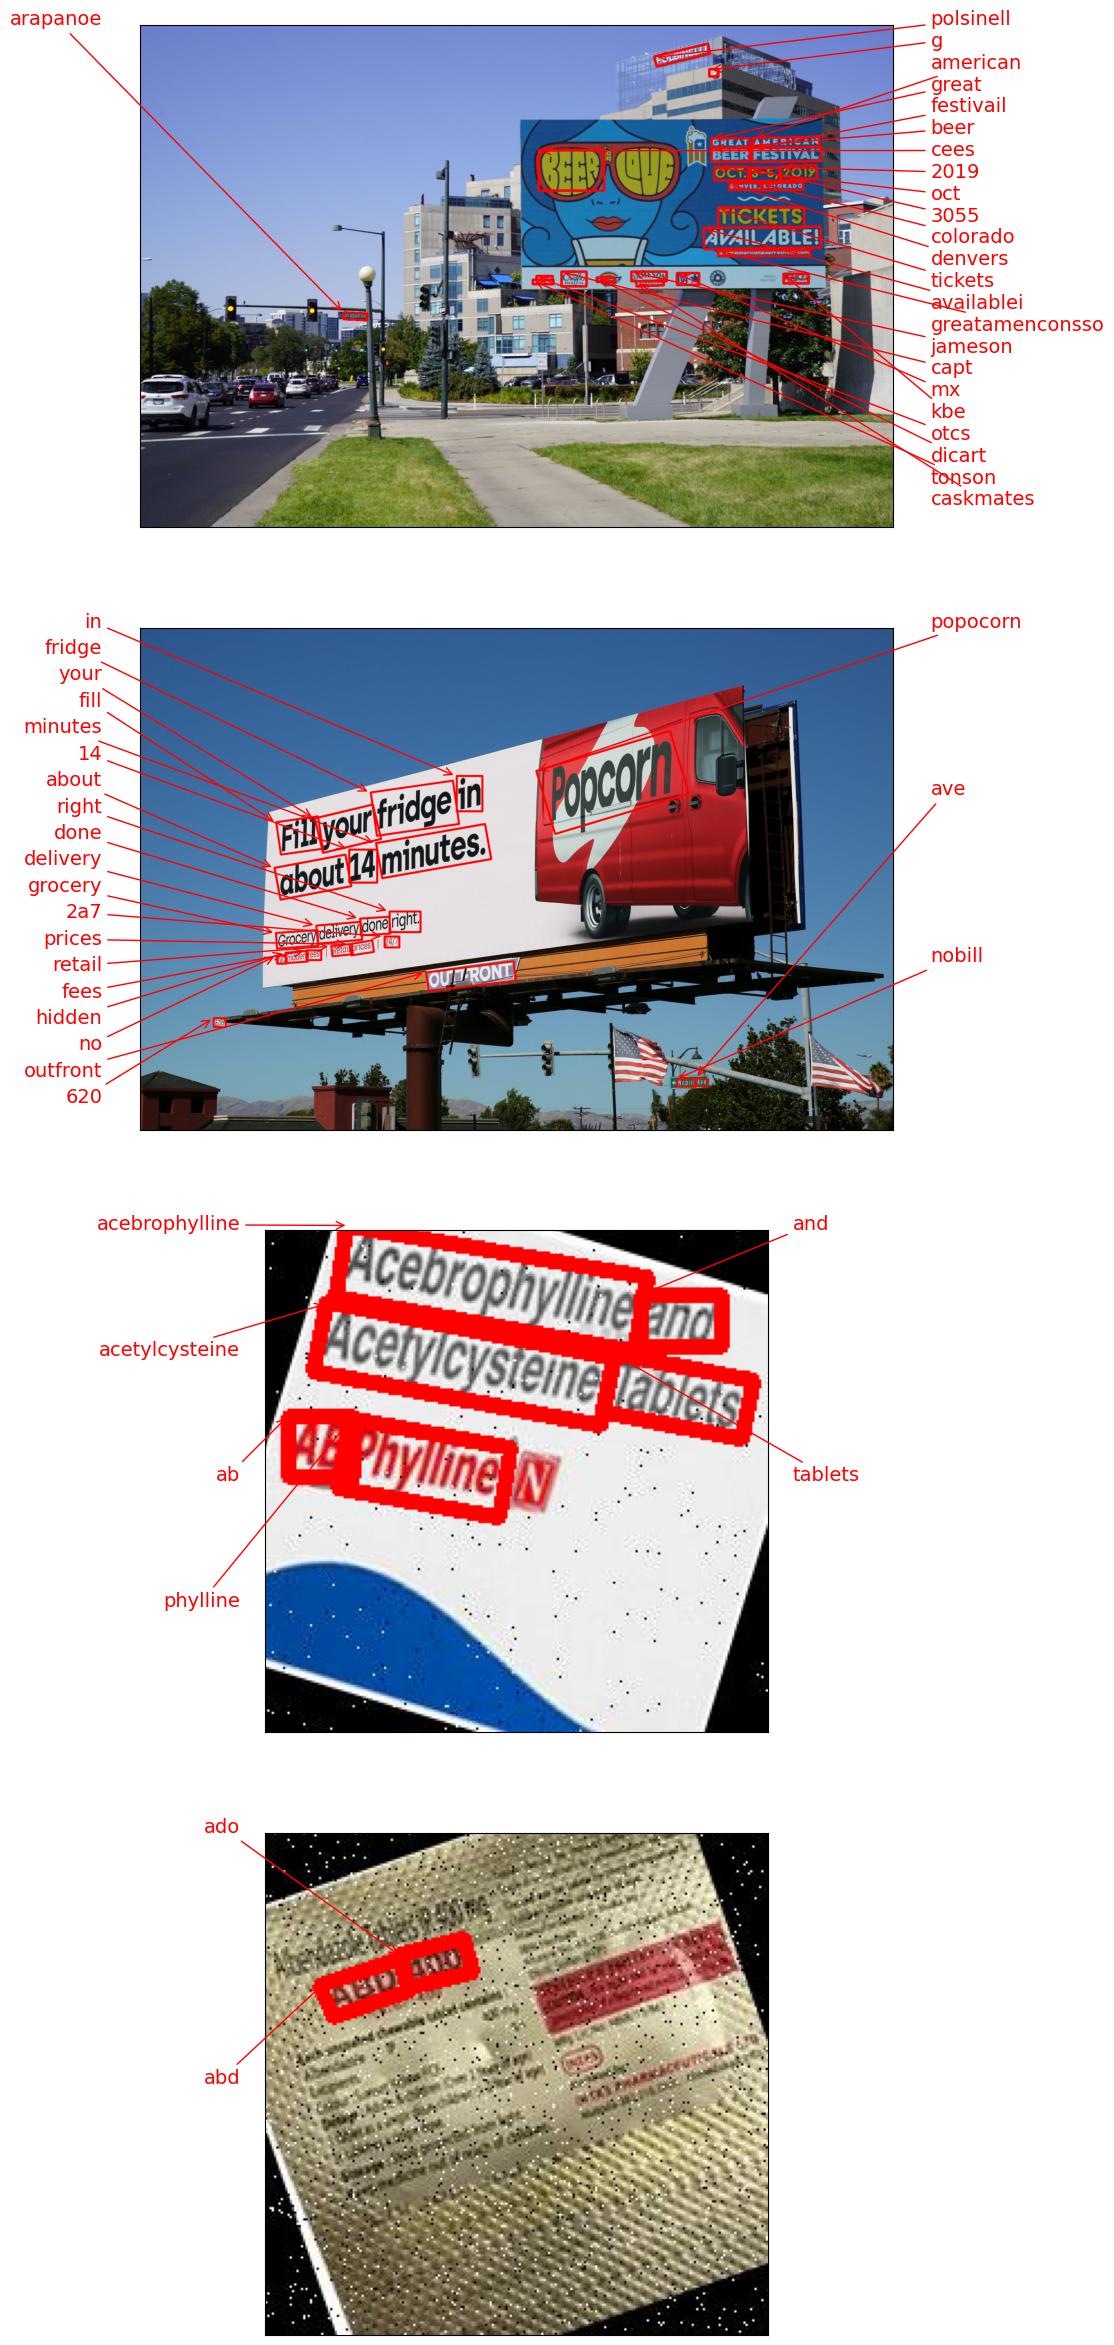

In [21]:
fig, axs = plt.subplots(nrows =len(images), figsize =(30,30))
for ax, image, prediction in zip(axs, images, result):
  keras_ocr.tools.drawAnnotations(image = image, predictions = prediction, ax= ax)

In [22]:
predicted_image = result[1]
for text, box in predicted_image:
    print(text)

popocorn
in
fridge
your
fill
minutes
14
about
right
done
delivery
grocery
2a7
prices
retail
fees
hidden
no
outfront
620
ave
nobill


In [23]:
predicted_image = result[2]
for text, box in predicted_image:
    print(text)

acebrophylline
and
acetylcysteine
tablets
ab
phylline
